# MADSci Utilization Plots

This notebook generates visualizations for MADSci utilization reports


In [43]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from madsci.client.event_client import EventClient

warnings.filterwarnings("ignore")

In [44]:
# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 12

print("MADSci Utilization Visualization Notebook")
print("Libraries loaded successfully")

# Cell 2: Initialize EventClient and fetch reports
# Initialize the event client
client = EventClient()

MADSci Utilization Visualization Notebook
Libraries loaded successfully


### Fetch analysis reports for: 
- Daily analysis 
- User anlaysis 
- Workcell session analysis

In [45]:
try:
    # Periods report (daily analysis)
    periods_report = client.get_utilization_periods(
        analysis_type="daily",
        user_timezone="America/Chicago",
        include_users=True,
        csv_export=False,  # JSON format
    )

    # User utilization report
    user_report = client.get_user_utilization_report(
        csv_export=False  # JSON format
    )

    # Session utilization report
    session_report = client.get_session_utilization(
        csv_export=False  # JSON format
    )

    print("Reports fetched successfully!")
    print(
        f"Periods report periods: {periods_report.get('summary_metadata', {}).get('total_periods', 'N/A')}"
    )
    print(
        f"User report users: {user_report.get('report_metadata', {}).get('total_users', 'N/A')}"
    )
    print(
        f"Session report sessions: {session_report.get('overall_summary', {}).get('total_sessions', 'N/A')}"
    )

except Exception as e:
    print(f"Error fetching reports: {e}")
    periods_report = user_report = session_report = None

Reports fetched successfully!
Periods report periods: 3
User report users: 2
Session report sessions: 3


In [46]:
print(periods_report)

{'summary_metadata': {'analysis_type': 'daily', 'generated_at': '2025-08-08T21:59:50.738352+00:00', 'period_start': '2025-08-06T10:40:15.031768', 'period_end': '2025-08-08T22:00:45.273081', 'user_timezone': 'America/Chicago', 'total_periods': 3, 'method': 'session_based_analysis_with_experiment_details_refactored'}, 'key_metrics': {'average_utilization': 0.03, 'peak_utilization': 0.05, 'peak_period': '2025-08-08', 'peak_context': 'Peak utilization on 2025-08-08', 'total_experiments': 4, 'total_runtime_hours': 52.33, 'total_active_time_hours': 0.01, 'active_periods': 2, 'total_periods': 3}, 'user_utilization': {'total_users': 2, 'author_attribution_rate_percent': 0.0, 'top_users': [{'author': 'Doga Ozgulbas', 'total_workflows': 2, 'total_runtime_hours': 0.01, 'completion_rate_percent': 100.0, 'average_workflow_duration_hours': 0.004}, {'author': 'Doga Yamac', 'total_workflows': 1, 'total_runtime_hours': 0.0, 'completion_rate_percent': 100.0, 'average_workflow_duration_hours': 0.004}], '

### Helper functions for data extraction

In [47]:
def extract_periods_data(periods_report):
    """Extract time series and node data from periods report."""
    if not periods_report or "time_series" not in periods_report:
        return None, None

    # Extract system time series data
    system_data = periods_report["time_series"].get("system", [])
    if not system_data:
        return None, None

    # Convert to DataFrame
    df = pd.DataFrame(system_data)

    # Extract node data
    node_data = periods_report["time_series"].get("nodes", {})

    return df, node_data


def extract_user_data(user_report):
    """Extract user statistics from user report."""
    if not user_report or "user_utilization" not in user_report:
        return None

    users_data = []
    for user_id, user_info in user_report["user_utilization"].items():
        users_data.append(
            {
                "author": user_info.get("author", "Unknown"),
                "total_workflows": user_info.get("total_workflows", 0),
                "completed_workflows": user_info.get("completed_workflows", 0),
                "failed_workflows": user_info.get("failed_workflows", 0),
                "cancelled_workflows": user_info.get("cancelled_workflows", 0),
                "total_runtime_hours": user_info.get("total_runtime_hours", 0),
                "completion_rate_percent": user_info.get("completion_rate_percent", 0),
                "average_workflow_duration_hours": user_info.get(
                    "average_workflow_duration_hours", 0
                ),
            }
        )

    return pd.DataFrame(users_data) if users_data else None


def extract_session_data(session_report):
    """Extract session data from session report."""
    if not session_report:
        return None, None

    sessions = session_report.get("session_details", [])
    summary = session_report.get("overall_summary", {})

    if not sessions:
        return None, summary

    session_data = []
    for session in sessions:
        session_data.append(
            {
                "session_name": session.get("session_name", "Unknown"),
                "session_type": session.get("session_type", "unknown"),
                "duration_hours": session.get("duration_hours", 0),
                "active_time_hours": session.get("active_time_hours", 0),
                "system_utilization_percent": session.get(
                    "system_utilization_percent", 0
                ),
                "total_experiments": session.get("total_experiments", 0),
                "start_time": session.get("start_time", ""),
                "end_time": session.get("end_time", ""),
            }
        )

    return pd.DataFrame(session_data), summary


### Utilization Periods Report Visualizations

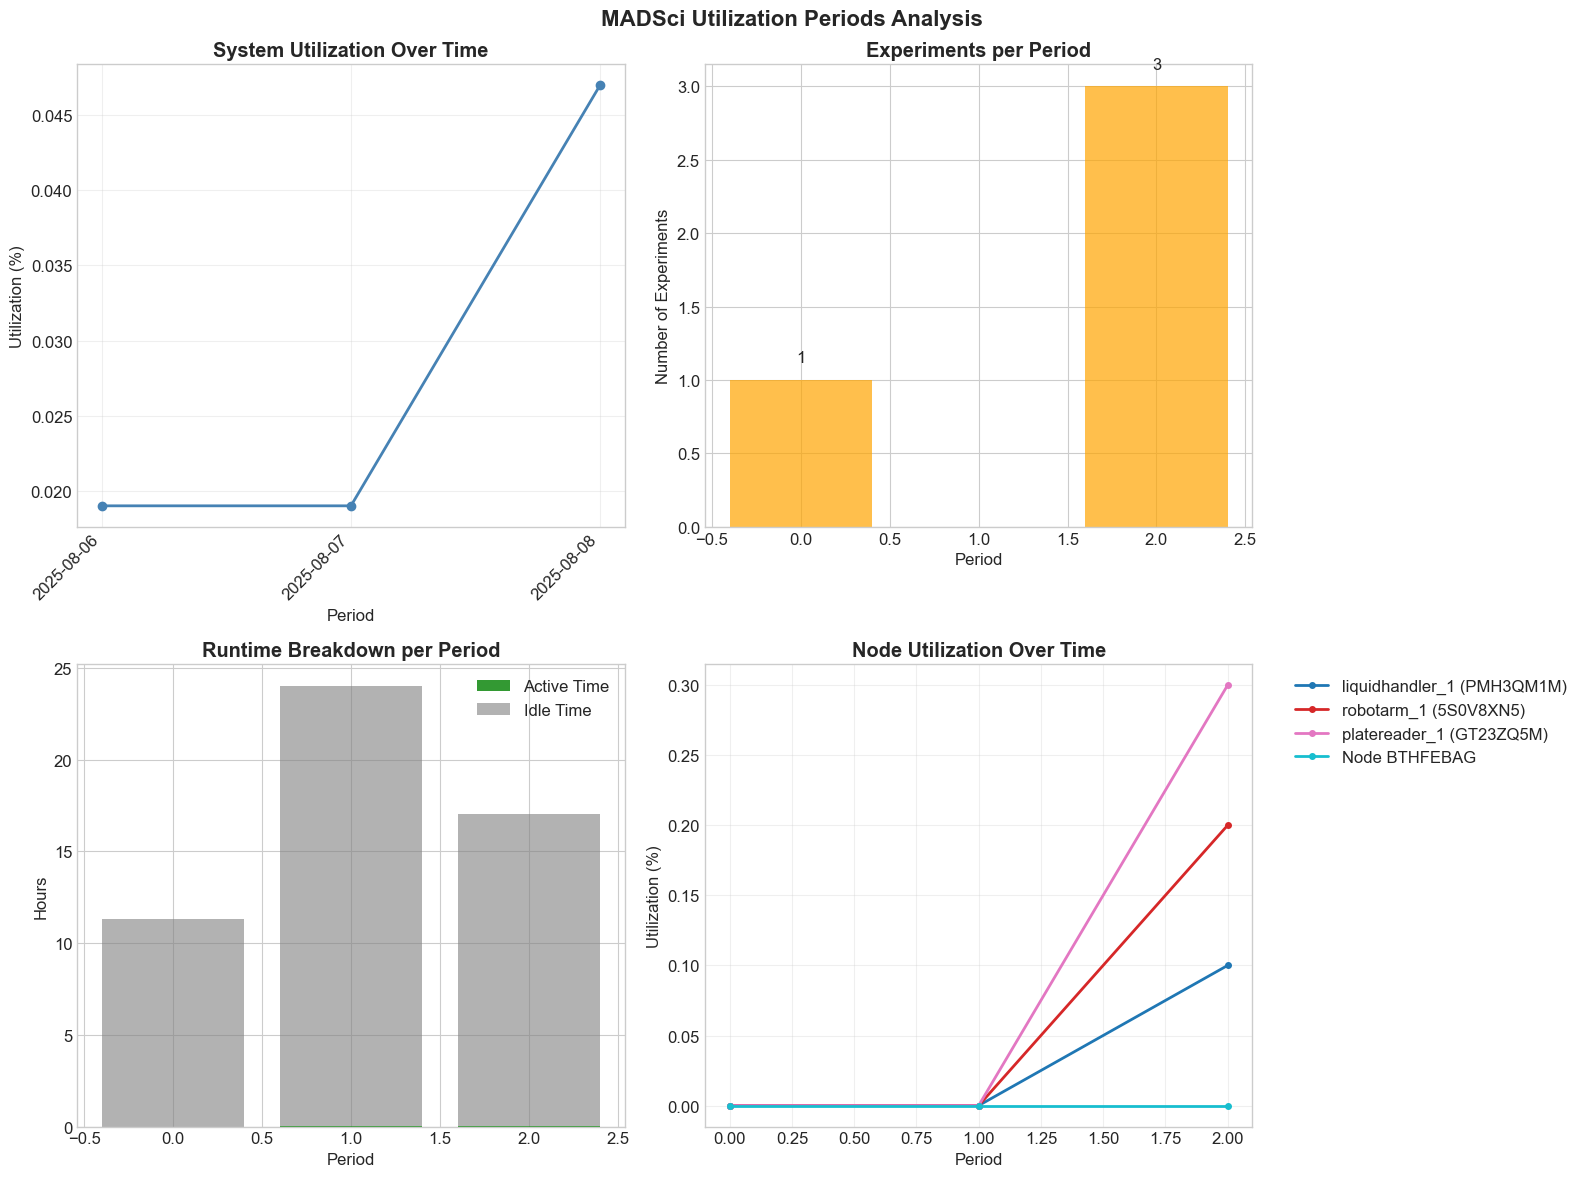

Periods Report Summary:
Total Periods: 3
Average Utilization: 0.0%
Peak Utilization: 0.0%
Total Experiments: 4


In [48]:
def plot_periods_analysis(periods_report):
    """Create visualizations for periods report."""
    if not periods_report:
        print("No periods report data available")
        return

    # Extract data
    df, node_data = extract_periods_data(periods_report)
    if df is None or df.empty:
        print("No time series data found in periods report")
        return

    # Create subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("MADSci Utilization Periods Analysis", fontsize=16, fontweight="bold")

    # 1. System utilization over time (line plot)
    ax1 = axes[0, 0]
    ax1.plot(
        range(len(df)),
        df["utilization"],
        marker="o",
        linewidth=2,
        markersize=6,
        color="steelblue",
    )
    ax1.set_title("System Utilization Over Time", fontweight="bold")
    ax1.set_xlabel("Period")
    ax1.set_ylabel("Utilization (%)")
    ax1.grid(True, alpha=0.3)

    # Set x-axis labels
    if "period_display" in df.columns:
        tick_positions = range(0, len(df), max(1, len(df) // 10))  # Show max 10 labels
        ax1.set_xticks(tick_positions)
        ax1.set_xticklabels(
            [df.iloc[i]["period_display"] for i in tick_positions],
            rotation=45,
            ha="right",
        )

    # 2. Experiments per period (bar chart)
    ax2 = axes[0, 1]
    bars = ax2.bar(range(len(df)), df["experiments"], alpha=0.7, color="orange")
    ax2.set_title("Experiments per Period", fontweight="bold")
    ax2.set_xlabel("Period")
    ax2.set_ylabel("Number of Experiments")

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            ax2.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.1,
                f"{int(height)}",
                ha="center",
                va="bottom",
            )

    # 3. Runtime breakdown (stacked bar)
    ax3 = axes[1, 0]
    if "runtime_hours" in df.columns and "active_time_hours" in df.columns:
        active_time = df["active_time_hours"].fillna(0)
        idle_time = df["runtime_hours"].fillna(0) - active_time

        ax3.bar(
            range(len(df)), active_time, label="Active Time", alpha=0.8, color="green"
        )
        ax3.bar(
            range(len(df)),
            idle_time,
            bottom=active_time,
            label="Idle Time",
            alpha=0.6,
            color="gray",
        )
        ax3.set_title("Runtime Breakdown per Period", fontweight="bold")
        ax3.set_xlabel("Period")
        ax3.set_ylabel("Hours")
        ax3.legend()
    else:
        ax3.text(
            0.5,
            0.5,
            "Runtime breakdown data not available",
            ha="center",
            va="center",
            transform=ax3.transAxes,
        )
        ax3.set_title("Runtime Breakdown per Period", fontweight="bold")

    # 4. Node utilization (multi-line plot)
    ax4 = axes[1, 1]
    if node_data and len(node_data) > 0:
        colors = plt.cm.tab10(np.linspace(0, 1, len(node_data)))

        for i, (node_id, node_time_series) in enumerate(node_data.items()):
            if node_time_series:
                node_df = pd.DataFrame(node_time_series)
                if "utilization" in node_df.columns:
                    # Get node name for display
                    node_summary = periods_report.get("node_summary", {}).get(
                        node_id, {}
                    )
                    node_name = node_summary.get("display_name", f"Node {node_id[-8:]}")

                    ax4.plot(
                        range(len(node_df)),
                        node_df["utilization"],
                        marker="o",
                        linewidth=2,
                        markersize=4,
                        color=colors[i],
                        label=node_name,
                    )

        ax4.set_title("Node Utilization Over Time", fontweight="bold")
        ax4.set_xlabel("Period")
        ax4.set_ylabel("Utilization (%)")
        ax4.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(
            0.5,
            0.5,
            "No node data available",
            ha="center",
            va="center",
            transform=ax4.transAxes,
        )
        ax4.set_title("Node Utilization Over Time", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Periods Report Summary:")
    print(f"Total Periods: {len(df)}")
    print(f"Average Utilization: {df['utilization'].mean():.1f}%")
    print(f"Peak Utilization: {df['utilization'].max():.1f}%")
    print(f"Total Experiments: {df['experiments'].sum()}")


# Generate periods visualizations
if periods_report:
    plot_periods_analysis(periods_report)
else:
    print("Skipping periods analysis - no data available")

### User Utilization Report Visualizations

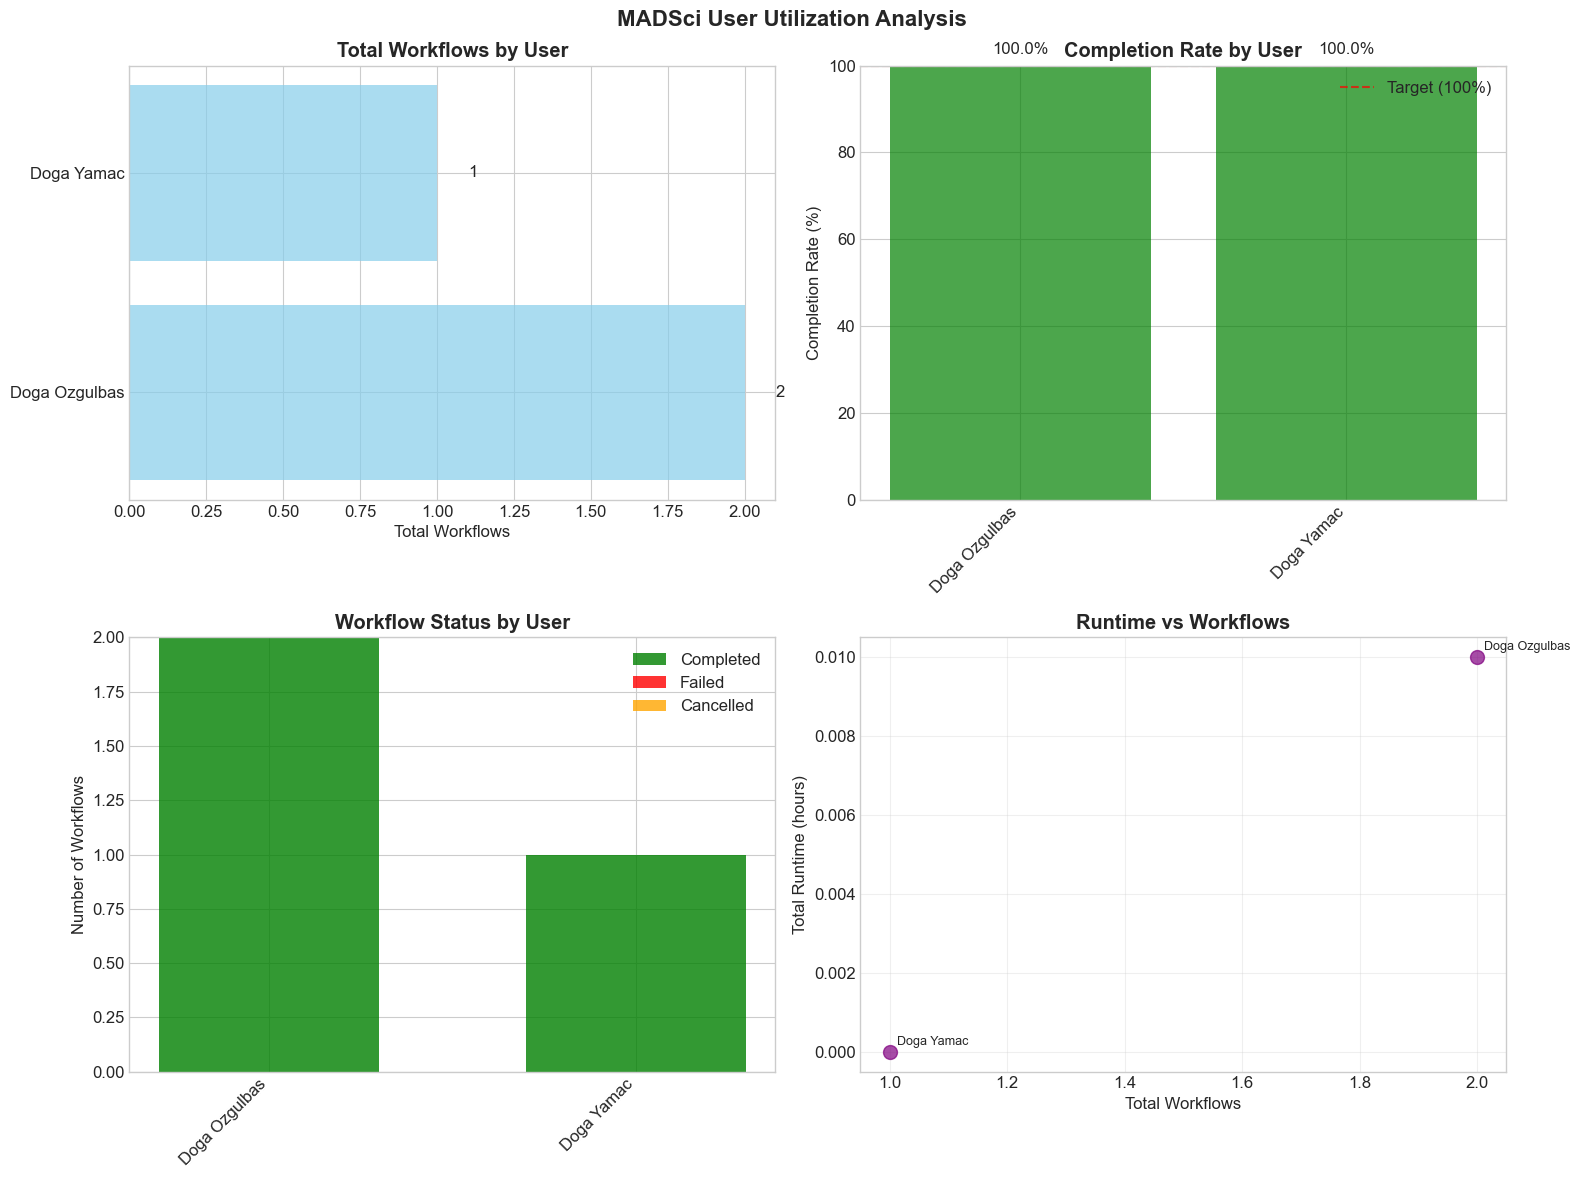

User Report Summary:
Total Users: 2
Total Workflows: 3
Overall Completion Rate: 100.0%


In [49]:
def plot_user_analysis(user_report):
    """Create visualizations for user report."""
    if not user_report:
        print("No user report data available")
        return

    df = extract_user_data(user_report)
    if df is None or df.empty:
        print("No user data found in user report")
        return

    # Create subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("MADSci User Utilization Analysis", fontsize=16, fontweight="bold")

    # 1. Total workflows by user (horizontal bar)
    ax1 = axes[0, 0]
    y_pos = range(len(df))
    bars = ax1.barh(y_pos, df["total_workflows"], alpha=0.7, color="skyblue")
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(df["author"])
    ax1.set_xlabel("Total Workflows")
    ax1.set_title("Total Workflows by User", fontweight="bold")

    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            ax1.text(
                width + 0.1,
                bar.get_y() + bar.get_height() / 2,
                f"{int(width)}",
                ha="left",
                va="center",
            )

    # 2. Completion rate by user (bar chart)
    ax2 = axes[0, 1]
    bars = ax2.bar(
        range(len(df)), df["completion_rate_percent"], alpha=0.7, color="green"
    )
    ax2.set_xticks(range(len(df)))
    ax2.set_xticklabels(df["author"], rotation=45, ha="right")
    ax2.set_ylabel("Completion Rate (%)")
    ax2.set_title("Completion Rate by User", fontweight="bold")
    ax2.set_ylim(0, 100)
    ax2.axhline(y=100, color="red", linestyle="--", alpha=0.7, label="Target (100%)")
    ax2.legend()

    # Add percentage labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 2,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
        )

    # 3. Workflow status breakdown (stacked bar)
    ax3 = axes[1, 0]
    if len(df) > 0:
        width = 0.6
        x_pos = range(len(df))

        completed = df["completed_workflows"]
        failed = df["failed_workflows"]
        cancelled = df["cancelled_workflows"]

        ax3.bar(x_pos, completed, width, label="Completed", color="green", alpha=0.8)
        ax3.bar(
            x_pos,
            failed,
            width,
            bottom=completed,
            label="Failed",
            color="red",
            alpha=0.8,
        )
        ax3.bar(
            x_pos,
            cancelled,
            width,
            bottom=completed + failed,
            label="Cancelled",
            color="orange",
            alpha=0.8,
        )

        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(df["author"], rotation=45, ha="right")
        ax3.set_ylabel("Number of Workflows")
        ax3.set_title("Workflow Status by User", fontweight="bold")
        ax3.legend()

    # 4. Runtime vs Workflows (scatter or summary)
    ax4 = axes[1, 1]
    if len(df) > 1:
        # Scatter plot for multiple users
        scatter = ax4.scatter(
            df["total_workflows"],
            df["total_runtime_hours"],
            s=100,
            alpha=0.7,
            color="purple",
        )

        # Add user labels
        for i, author in enumerate(df["author"]):
            ax4.annotate(
                author,
                (df["total_workflows"].iloc[i], df["total_runtime_hours"].iloc[i]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=9,
            )

        ax4.set_xlabel("Total Workflows")
        ax4.set_ylabel("Total Runtime (hours)")
        ax4.set_title("Runtime vs Workflows", fontweight="bold")
        ax4.grid(True, alpha=0.3)
    else:
        # Summary for single user
        ax4.axis("off")
        user = df.iloc[0]
        summary_text = f"""
        User: {user["author"]}
        
        Total Workflows: {user["total_workflows"]}
        Completed: {user["completed_workflows"]}
        Failed: {user["failed_workflows"]}
        Cancelled: {user["cancelled_workflows"]}
        
        Total Runtime: {user["total_runtime_hours"]:.2f}h
        Avg Duration: {user["average_workflow_duration_hours"]:.3f}h
        Completion Rate: {user["completion_rate_percent"]:.1f}%
        """
        ax4.text(
            0.1,
            0.9,
            summary_text,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.7),
            transform=ax4.transAxes,
        )
        ax4.set_title("User Summary", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Print summary
    print("User Report Summary:")
    print(f"Total Users: {len(df)}")
    print(f"Total Workflows: {df['total_workflows'].sum()}")
    if df["total_workflows"].sum() > 0:
        print(
            f"Overall Completion Rate: {(df['completed_workflows'].sum() / df['total_workflows'].sum() * 100):.1f}%"
        )


# Generate user visualizations
if user_report:
    plot_user_analysis(user_report)
else:
    print("Skipping user analysis - no data available")

### Session Utilization Report Visualizations

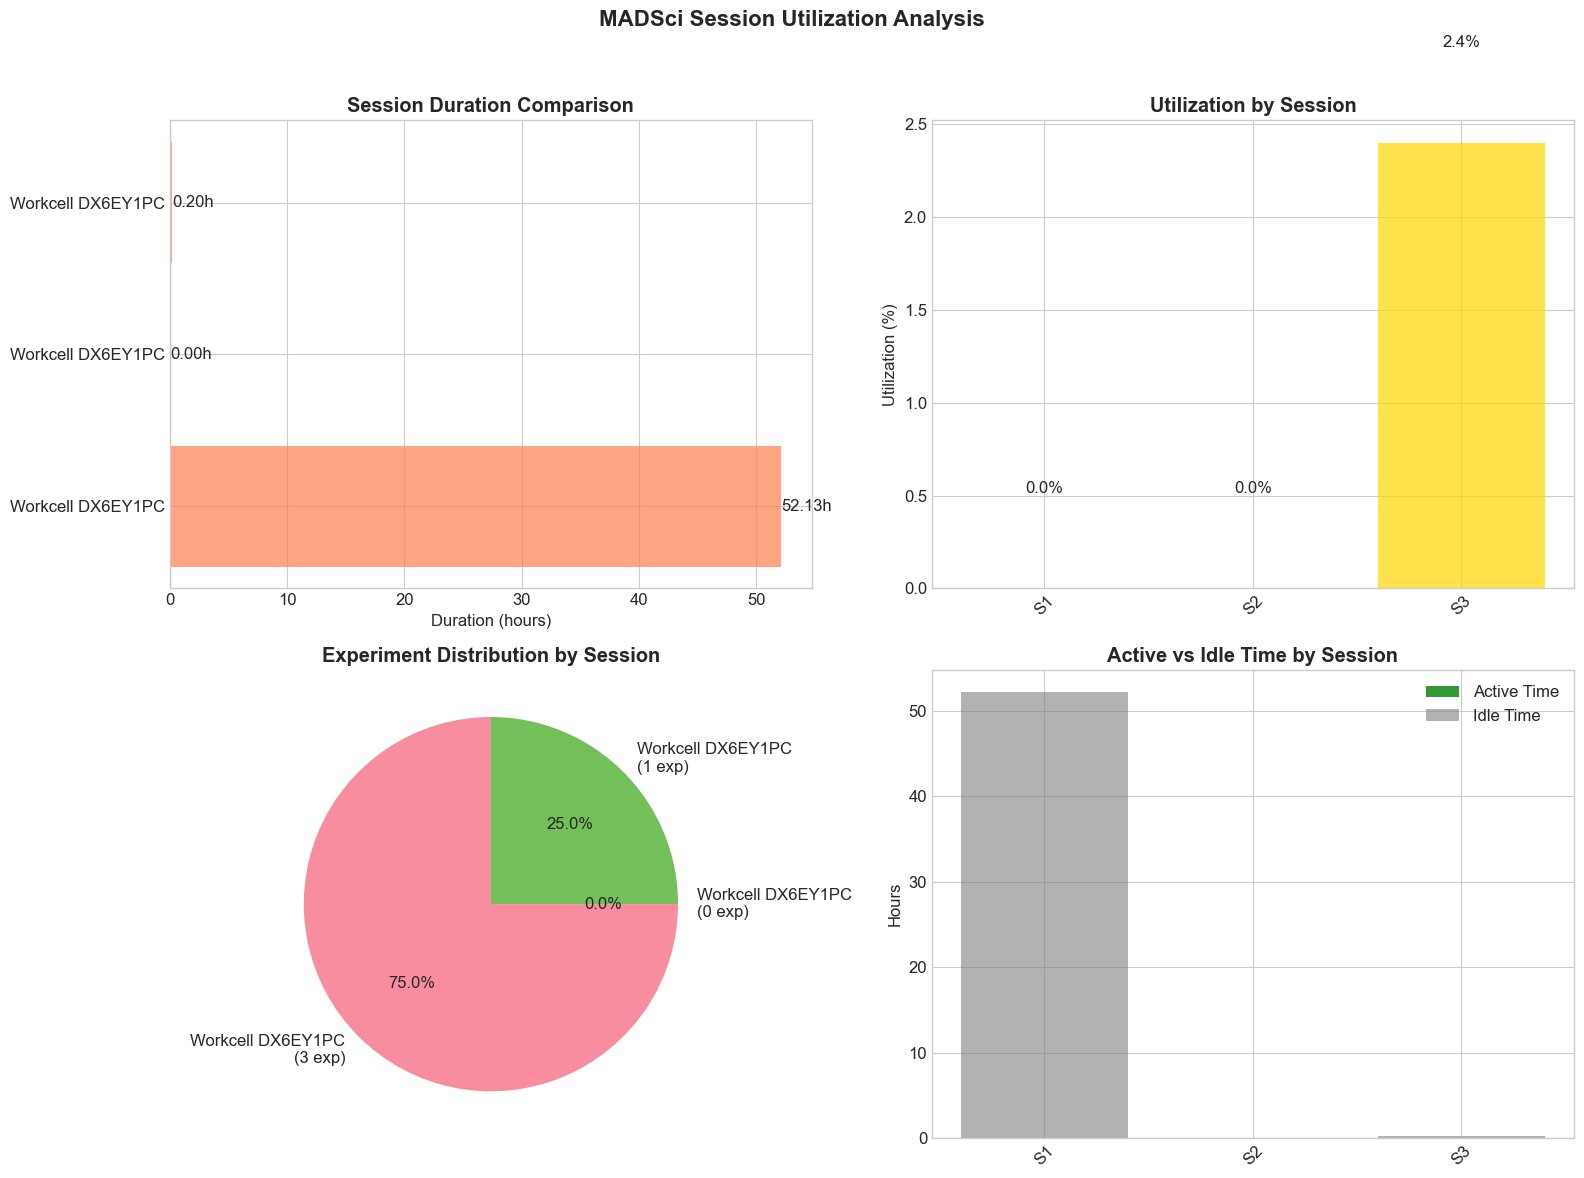

Session Report Summary:
Total Sessions: 3
Total Runtime: 52.3h
Average Utilization: 0.8%
Total Experiments: 4
Nodes Tracked: 4


In [50]:
def plot_session_analysis(session_report):
    """Create visualizations for session report."""
    if not session_report:
        print("No session report data available")
        return

    df, summary = extract_session_data(session_report)

    # Create subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("MADSci Session Utilization Analysis", fontsize=16, fontweight="bold")

    if df is not None and not df.empty:
        # 1. Session duration comparison (horizontal bar)
        ax1 = axes[0, 0]
        y_pos = range(len(df))
        bars = ax1.barh(y_pos, df["duration_hours"], alpha=0.7, color="coral")
        ax1.set_yticks(y_pos)
        ax1.set_yticklabels(df["session_name"])
        ax1.set_xlabel("Duration (hours)")
        ax1.set_title("Session Duration Comparison", fontweight="bold")

        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            if width > 0:
                ax1.text(
                    width + 0.01,
                    bar.get_y() + bar.get_height() / 2,
                    f"{width:.2f}h",
                    ha="left",
                    va="center",
                )

        # 2. Utilization by session (bar chart)
        ax2 = axes[0, 1]
        bars = ax2.bar(
            range(len(df)), df["system_utilization_percent"], alpha=0.7, color="gold"
        )
        ax2.set_xticks(range(len(df)))
        ax2.set_xticklabels([f"S{i + 1}" for i in range(len(df))], rotation=45)
        ax2.set_ylabel("Utilization (%)")
        ax2.set_title("Utilization by Session", fontweight="bold")

        # Add percentage labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.5,
                f"{height:.1f}%",
                ha="center",
                va="bottom",
            )

        # 3. Experiments distribution (pie chart) - FIXED
        ax3 = axes[1, 0]
        experiment_counts = df["total_experiments"]
        if experiment_counts.sum() > 0:
            # Create the pie chart without alpha parameter
            wedges, texts, autotexts = ax3.pie(
                experiment_counts,
                labels=[
                    f"{name}\n({count} exp)"
                    for name, count in zip(df["session_name"], experiment_counts)
                ],
                autopct="%1.1f%%",
                startangle=90,
            )

            # Apply transparency to wedges manually
            for wedge in wedges:
                wedge.set_alpha(0.8)

            ax3.set_title("Experiment Distribution by Session", fontweight="bold")
        else:
            ax3.text(0.5, 0.5, "No experiments found", ha="center", va="center")
            ax3.set_title("Experiment Distribution by Session", fontweight="bold")

        # 4. Active vs Idle time (stacked bar)
        ax4 = axes[1, 1]
        active_time = df["active_time_hours"]
        idle_time = df["duration_hours"] - df["active_time_hours"]

        x_pos = range(len(df))
        ax4.bar(x_pos, active_time, label="Active Time", alpha=0.8, color="green")
        ax4.bar(
            x_pos,
            idle_time,
            bottom=active_time,
            label="Idle Time",
            alpha=0.6,
            color="gray",
        )

        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([f"S{i + 1}" for i in range(len(df))], rotation=45)
        ax4.set_ylabel("Hours")
        ax4.set_title("Active vs Idle Time by Session", fontweight="bold")
        ax4.legend()

    else:
        # No session data - show summary only
        for ax in axes.flat:
            ax.axis("off")

        axes[0, 0].text(
            0.5,
            0.5,
            "No session details available",
            ha="center",
            va="center",
            transform=axes[0, 0].transAxes,
        )
        axes[0, 0].set_title("Session Analysis", fontweight="bold")

    plt.tight_layout()
    plt.show()

    # Print summary
    if summary:
        print("Session Report Summary:")
        print(f"Total Sessions: {summary.get('total_sessions', 0)}")
        print(f"Total Runtime: {summary.get('total_system_runtime_hours', 0):.1f}h")
        print(
            f"Average Utilization: {summary.get('average_system_utilization_percent', 0):.1f}%"
        )
        print(f"Total Experiments: {summary.get('total_experiments', 0)}")
        print(f"Nodes Tracked: {summary.get('nodes_tracked', 0)}")


# Generate session visualizations
if session_report:
    plot_session_analysis(session_report)
else:
    print("Skipping session analysis - no data available")

### Summary Dashboard

Creating summary dashboard...


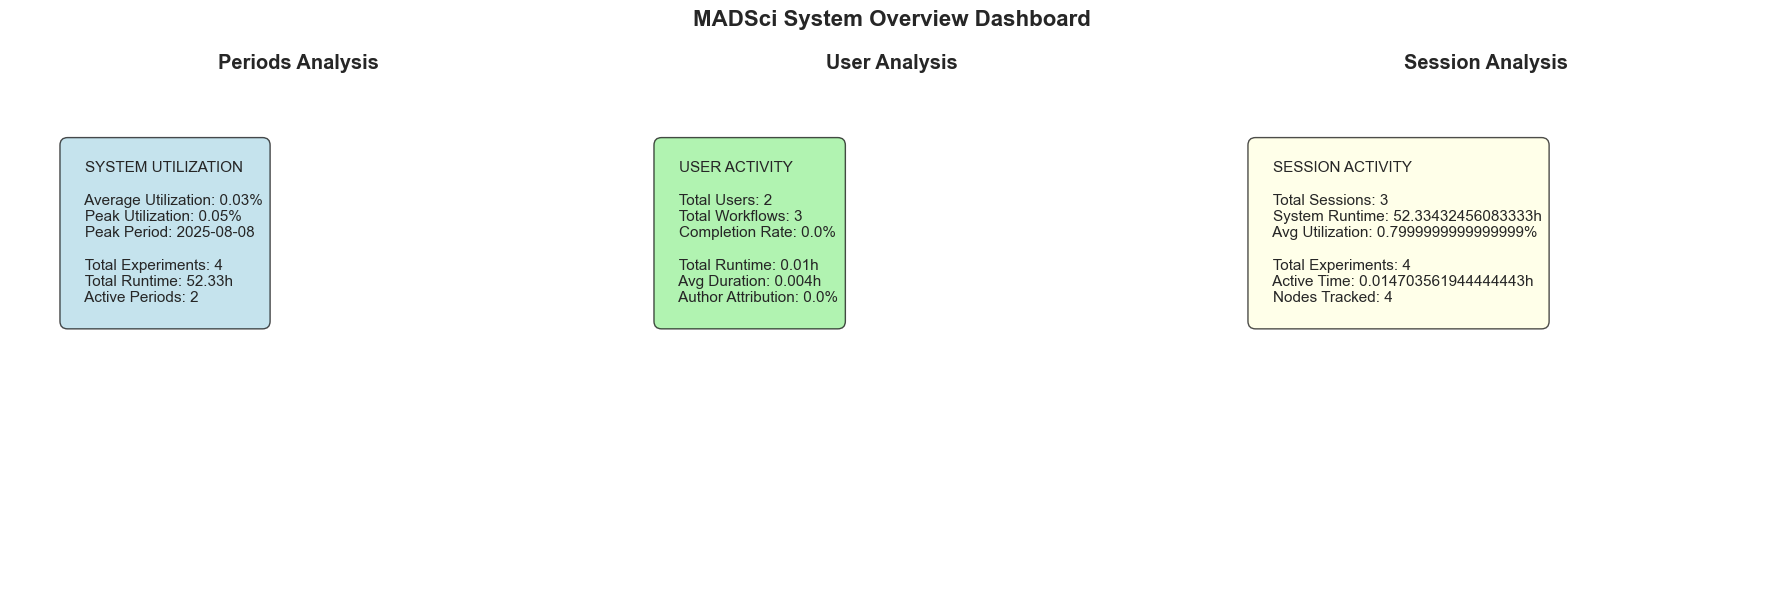


Visualization complete! All charts have been generated.
Note: Charts are displayed inline in the notebook.


In [51]:
def create_summary_dashboard():
    """Create an overall summary dashboard."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle("MADSci System Overview Dashboard", fontsize=16, fontweight="bold")

    # Extract key metrics from each report
    periods_metrics = {}
    user_metrics = {}
    session_metrics = {}

    if periods_report and "key_metrics" in periods_report:
        periods_metrics = periods_report["key_metrics"]

    if user_report and "system_summary" in user_report:
        user_metrics = user_report["system_summary"]

    if session_report and "overall_summary" in session_report:
        session_metrics = session_report["overall_summary"]

    # 1. System Utilization Summary
    ax1 = axes[0]
    ax1.axis("off")
    periods_text = f"""
    SYSTEM UTILIZATION
    
    Average Utilization: {periods_metrics.get("average_utilization", "N/A")}%
    Peak Utilization: {periods_metrics.get("peak_utilization", "N/A")}%
    Peak Period: {periods_metrics.get("peak_period", "N/A")}
    
    Total Experiments: {periods_metrics.get("total_experiments", "N/A")}
    Total Runtime: {periods_metrics.get("total_runtime_hours", "N/A")}h
    Active Periods: {periods_metrics.get("active_periods", "N/A")}
    """
    ax1.text(
        0.1,
        0.9,
        periods_text,
        fontsize=11,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7),
        transform=ax1.transAxes,
    )
    ax1.set_title("Periods Analysis", fontweight="bold", pad=20)

    # 2. User Activity Summary
    ax2 = axes[1]
    ax2.axis("off")
    user_text = f"""
    USER ACTIVITY
    
    Total Users: {user_report.get("report_metadata", {}).get("total_users", "N/A") if user_report else "N/A"}
    Total Workflows: {user_metrics.get("total_workflows", "N/A")}
    Completion Rate: {user_metrics.get("completion_rate_percent", "N/A")}%
    
    Total Runtime: {user_metrics.get("total_runtime_hours", "N/A")}h
    Avg Duration: {user_metrics.get("average_workflow_duration_hours", "N/A")}h
    Author Attribution: {user_metrics.get("author_attribution_rate_percent", "N/A")}%
    """
    ax2.text(
        0.1,
        0.9,
        user_text,
        fontsize=11,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.7),
        transform=ax2.transAxes,
    )
    ax2.set_title("User Analysis", fontweight="bold", pad=20)

    # 3. Session Summary
    ax3 = axes[2]
    ax3.axis("off")
    session_text = f"""
    SESSION ACTIVITY
    
    Total Sessions: {session_metrics.get("total_sessions", "N/A")}
    System Runtime: {session_metrics.get("total_system_runtime_hours", "N/A")}h
    Avg Utilization: {session_metrics.get("average_system_utilization_percent", "N/A")}%
    
    Total Experiments: {session_metrics.get("total_experiments", "N/A")}
    Active Time: {session_metrics.get("total_active_time_hours", "N/A")}h
    Nodes Tracked: {session_metrics.get("nodes_tracked", "N/A")}
    """
    ax3.text(
        0.1,
        0.9,
        session_text,
        fontsize=11,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.7),
        transform=ax3.transAxes,
    )
    ax3.set_title("Session Analysis", fontweight="bold", pad=20)

    plt.tight_layout()
    plt.show()


# Generate summary dashboard
print("Creating summary dashboard...")
create_summary_dashboard()

print("\nVisualization complete! All charts have been generated.")
print("Note: Charts are displayed inline in the notebook.")